# Bounding Box Regressor - Training
This notebook contains the code base used to train the bone fracture detector. It is heavily based on [this](https://jovian.ai/aakanksha-ns/road-signs-bounding-box-prediction).

In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
images_path = Path('/home/thilo/bb_test/custom_data/images')
anno_path = Path('/home/thilo/bb_test/custom_data/labels')

## Loading the data

In [4]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [5]:
df_train = generate_train_df(anno_path)

In [6]:
#label encode target
class_dict = {'fracture': 0}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [7]:
print(df_train.shape)
df_train.head()

(13, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,/home/thilo/bb_test/custom_data/images/postpro...,640,480,0,242,240,319,319
1,/home/thilo/bb_test/custom_data/images/postpro...,640,480,0,43,197,187,337
2,/home/thilo/bb_test/custom_data/images/postpro...,640,480,0,230,226,373,289
3,/home/thilo/bb_test/custom_data/images/postpro...,640,480,0,325,265,435,324
4,/home/thilo/bb_test/custom_data/images/postpro...,640,480,0,245,226,359,319


## Resizing images and bounding boxes

In [8]:
#Reading an image
def read_image(path):
    print(str(path))
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [9]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [10]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [11]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('/home/thilo/bb_test/custom_data/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

/home/thilo/bb_test/custom_data/images/postprocessed_hand_130.jpg
/home/thilo/bb_test/custom_data/images/postprocessed_hand_25.jpg
/home/thilo/bb_test/custom_data/images/postprocessed_hand_63.jpg
/home/thilo/bb_test/custom_data/images/postprocessed_hand_30.jpg
/home/thilo/bb_test/custom_data/images/postprocessed_hand_1101.jpg
/home/thilo/bb_test/custom_data/images/postprocessed_hand_81.jpg
/home/thilo/bb_test/custom_data/images/postprocessed_hand_156.jpg
/home/thilo/bb_test/custom_data/images/postprocessed_hand_27.jpg
/home/thilo/bb_test/custom_data/images/postprocessed_hand_114.jpg
/home/thilo/bb_test/custom_data/images/postprocessed_hand_1212.jpg
/home/thilo/bb_test/custom_data/images/postprocessed_hand_7.jpg
/home/thilo/bb_test/custom_data/images/postprocessed_hand_171.jpg
/home/thilo/bb_test/custom_data/images/postprocessed_hand_15.jpg


/tmp/ipykernel_4210/83097149.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


## Sample Image

In [12]:
im = cv2.imread(str(df_train.values[0][0]))
bb = create_bb_array(df_train.values[0])
print(im.shape)

(480, 640, 3)


In [13]:
Y = create_mask(bb, im)
mask_to_bb(Y)

/tmp/ipykernel_4210/83097149.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


array([240., 242., 318., 318.], dtype=float32)

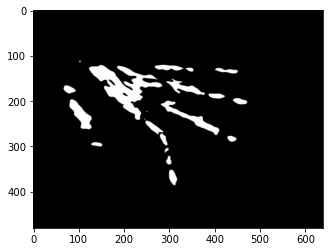

In [14]:
plt.imshow(im)

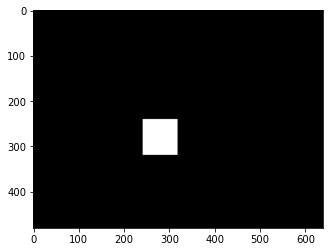

In [15]:
plt.imshow(Y, cmap='gray')

## Data augmentation

In [16]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


In [17]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [18]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

## Sample Image

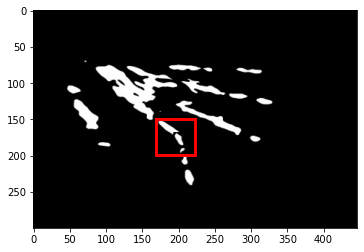

In [19]:
#original
im = cv2.imread(str(df_train.values[0][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[0][9])

## Testset split

In [20]:
df_train = df_train.reset_index()

In [21]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.5, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

## Dataset

In [23]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [24]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [25]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [26]:
batch_size = 8
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

## Model

In [27]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

## Training

In [28]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [29]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total


In [30]:
def val_metrics(model, valid_dl, C=1):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [31]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

/home/thilo/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/thilo/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=150)

/tmp/ipykernel_4210/83097149.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


train_loss 695.805 val_loss 688.206 val_acc 1.000
train_loss 681.960 val_loss 8092970.286 val_acc 0.000
train_loss 706.371 val_loss 43416256512.000 val_acc 0.000
train_loss 727.206 val_loss 34277130240.000 val_acc 0.000
train_loss 769.515 val_loss 9261345060.571 val_acc 0.000
train_loss 735.010 val_loss 2225765229.714 val_acc 0.000
train_loss 716.317 val_loss 889650688.000 val_acc 0.000
train_loss 712.193 val_loss 373492809.143 val_acc 0.000
train_loss 709.145 val_loss 134926976.000 val_acc 0.000
train_loss 695.712 val_loss 48181120.000 val_acc 0.000
train_loss 726.766 val_loss 18759467.429 val_acc 0.000
train_loss 750.867 val_loss 7538856.000 val_acc 0.000
train_loss 733.263 val_loss 3635153.714 val_acc 0.000
train_loss 736.947 val_loss 1756614.286 val_acc 0.000
train_loss 735.298 val_loss 1006042.357 val_acc 0.000
train_loss 712.606 val_loss 557832.786 val_acc 0.000
train_loss 731.390 val_loss 383583.393 val_acc 0.000
train_loss 697.110 val_loss 252649.018 val_acc 0.000
train_loss 71

70.32676188151042

In [33]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

/tmp/ipykernel_4210/83097149.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


train_loss 48.560 val_loss 501.741 val_acc 1.000
train_loss 54.557 val_loss 481.926 val_acc 1.000
train_loss 75.741 val_loss 464.275 val_acc 1.000
train_loss 59.396 val_loss 449.461 val_acc 1.000
train_loss 55.233 val_loss 435.572 val_acc 1.000
train_loss 48.661 val_loss 421.803 val_acc 1.000
train_loss 56.069 val_loss 407.170 val_acc 1.000
train_loss 77.135 val_loss 399.180 val_acc 1.000
train_loss 70.282 val_loss 392.489 val_acc 1.000
train_loss 72.424 val_loss 382.568 val_acc 1.000


72.42389424641927

## Making predictions

In [34]:
# choose random image from validation set
X_val

,new_path,new_bb
11,/home/thilo/bb_test/custom_data/images_resized...,"[161.0, 180.0, 197.0, 262.0]"
9,/home/thilo/bb_test/custom_data/images_resized...,"[120.0, 188.0, 157.0, 285.0]"
0,/home/thilo/bb_test/custom_data/images_resized...,"[150.0, 169.0, 199.0, 222.0]"
8,/home/thilo/bb_test/custom_data/images_resized...,"[133.0, 196.0, 169.0, 263.0]"
5,/home/thilo/bb_test/custom_data/images_resized...,"[48.0, 75.0, 121.0, 137.0]"
2,/home/thilo/bb_test/custom_data/images_resized...,"[141.0, 160.0, 180.0, 260.0]"
1,/home/thilo/bb_test/custom_data/images_resized...,"[123.0, 30.0, 210.0, 130.0]"


In [35]:
# resizing test image
im = read_image('/home/thilo/bb_test/custom_data/images_resized/postprocessed_hand_30.jpg')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('/home/thilo/bb_test/custom_data/test_images/postprocessed_hand_30.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

/home/thilo/bb_test/custom_data/images_resized/postprocessed_hand_30.jpg


True

In [36]:
# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':'/home/thilo/bb_test/custom_data/test_images/postprocessed_hand_30.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

/tmp/ipykernel_4210/83097149.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


In [37]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [38]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 5.5850, -1.9925, -2.7176, -2.8510]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[196.1815, 195.4120, 264.7242, 306.3172]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [39]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([5.5850], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

[196 195 264 306]


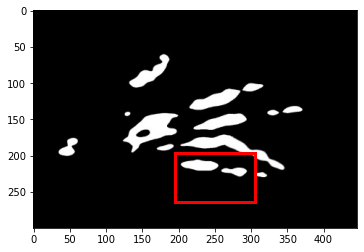

In [40]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])
print(bb_hat[0])

In [41]:
# save the model parameters
torch.save(model.state_dict(), "./model/model.pth")